## FASTERRCNN

In [1]:
# !pip install torch==1.11.0 

In [2]:


import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

from sklearn import model_selection

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
import os
import random
warnings.filterwarnings("ignore")



## Seed

In [3]:

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
#import torch_xla
#import torch_xla.core.xla_model as xm

In [5]:
# !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Read The Csv Files

### Train

In [6]:
train_df = pd.read_csv('../input/makerere-fruit-passion/New Makerere/New Makerere/Train(1).csv')
train_df.head()


,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [7]:
train_df.shape

(3906, 6)

In [8]:
No_duplicates = train_df.drop_duplicates(subset="Image_ID")
print(No_duplicates.shape)

(3001, 6)


#### We have 3906 bounding boxes, from a collection of 3001 images. Some images have 1 bounding box, while others have more than 1 bounding box.

## Test

In [9]:
test_df = pd.read_csv("../input/makerere-fruit-passion/New Makerere/New Makerere/Test.csv")
test_df.head()

,Image_ID
0,ID_IUJJG62B
1,ID_ZPNDRD4T
2,ID_AHFYB64P
3,ID_L8JZLNTF
4,ID_IFMUXGPL


In [10]:
test_df.shape

(931, 1)


## data preprocessing




###    Calculate the xmax and ymax from the train data

In [11]:
train_df['xmax'] = train_df['xmin']+train_df['width']
train_df['ymax'] = train_df['ymin']+train_df['height']

train_df = train_df.drop(columns = ['width','height'])

In [12]:
train_df.head()

,Image_ID,class,xmin,ymin,xmax,ymax
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,315.0,398.5
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,342.5,372.0
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,404.5,512.0
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,379.5,410.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,313.0,414.5


### Encode the classes from str to int

In [13]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [14]:
train_df.head()

,Image_ID,class,xmin,ymin,xmax,ymax
0,ID_007FAIEI,3,87.0,87.5,315.0,398.5
1,ID_00G8K1V3,1,97.5,17.5,342.5,372.0
2,ID_00WROUT9,1,156.5,209.5,404.5,512.0
3,ID_00ZJEEK3,2,125.0,193.0,379.5,410.0
4,ID_018UIENR,1,79.5,232.5,313.0,414.5


#### Most pretrained models reserve label 0 for the background class, therefore we encoded our labels from 1

In [15]:
df = train_df.copy() # create a copy of the train df

## Visualization

### Let's create sample plots for our Image and the corresponding bounding box



In [16]:
path = '../input/makerere-fruit-passion/New Makerere/New Makerere/Train_Images(1)/Train_Images/'

In [17]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['Image_ID'])

In [18]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


   xmin  ymin   xmax   ymax
0  87.0  87.5  315.0  398.5


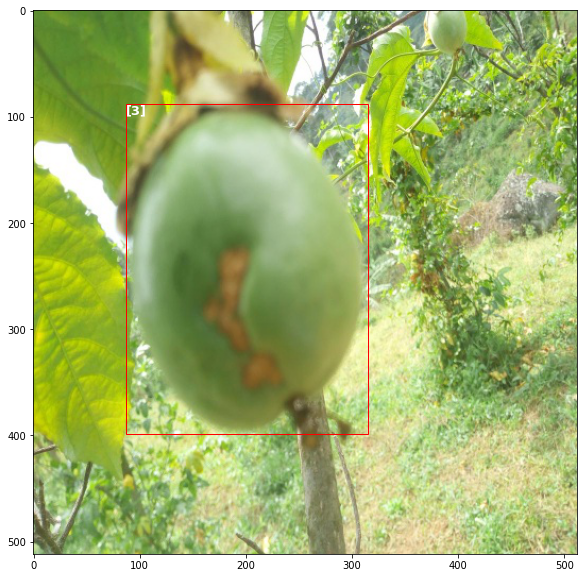

In [19]:
name = df.Image_ID.unique()[0]
plot_image(name)

      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5
      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5


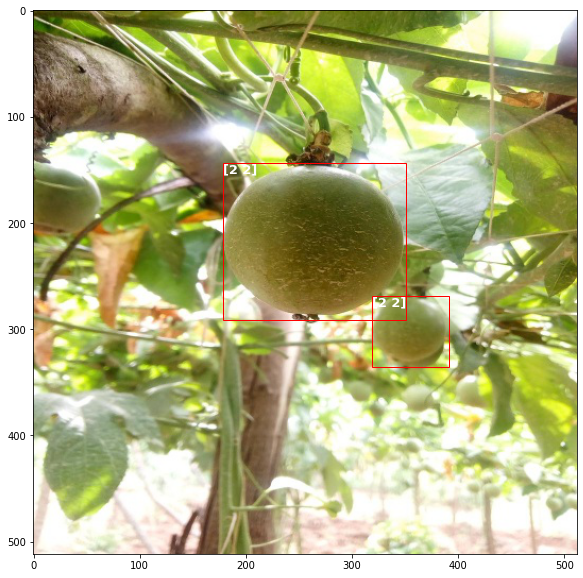

In [20]:
name = df.Image_ID.unique()[700]
plot_image(name)

     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0
     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0


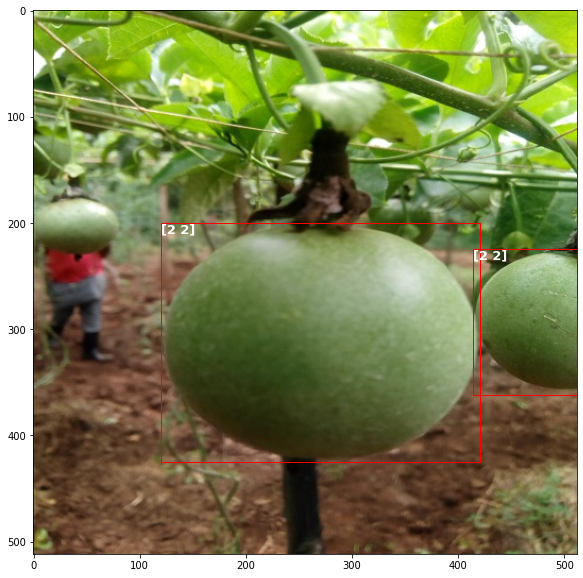

In [21]:
name = df.Image_ID.unique()[67]
plot_image(name)

## Create a custom Dataset



*     We'll create a custom dataset to load our images into PyTorch object detector.

*     Sample https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html



In [22]:
class PassionFruit(object):
    def __init__(self, df, IMG_DIR, transforms):
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique().tolist()
        self.transforms = transforms
    def __len__(self):
        return len(self.image_ids)
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)
        if self.transforms:
                sample = {
                                'image': image,
                                'bboxes': target['boxes'],
                                'labels': labels
                }
        sample = self.transforms(**sample)
        image = sample['image']
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)



        return torch.tensor(image), target, image_id

## AUGMENTATIONS

#### Remember in Our EDA we tried an augmentation pipeline, now we
#### define the image transformations. We'll use albumentations package: https://albumentations.ai/

In [23]:
def get_train_transform():
    return A.Compose([
        A.Resize(512,512),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        A.RandomBrightness(),
        A.RandomRotate90(),
        A.Rotate(limit=(-90, 90)),
        A.Transpose(),
        A.Downscale (),
        A.RandomContrast(),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
        A.Blur(),
#             A.ShiftScaleRotate(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Resize(512, 512), 
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [24]:
def get_train_transform():
    return A.Compose([
            A.Resize(512, 512), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ), 
            A.RandomBrightness(),
            A.RandomContrast(),
            
            A.RandomGamma(),        
            A.Downscale(),
            A.Blur(),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## load passion fruit dataset and perform the transormations

In [25]:
passion_dataset = PassionFruit(df, path, get_train_transform())

## Check if the custom dataset object created ealier works

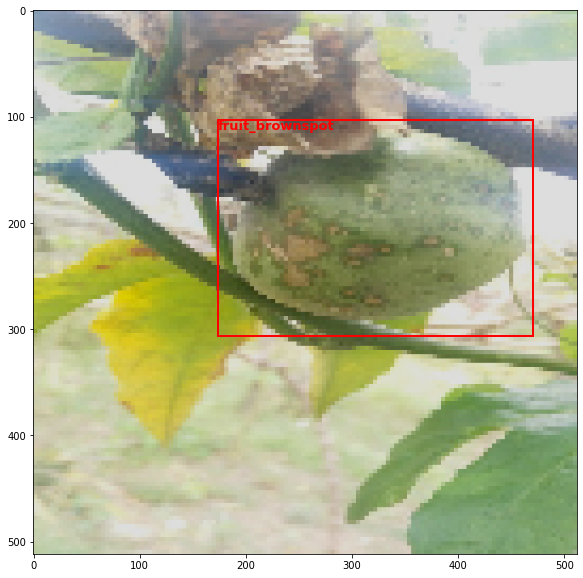

In [26]:
img, tar, _ = passion_dataset[random.randint(0,1000)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"fruit_brownspot",  2:"fruit_healthy", 3:"fruit_woodiness"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


## Splitting Data into Train and Test Data

In [27]:
# image_ids = df['Image_ID'].unique()
# valid_ids = image_ids[-665:]
# train_ids = image_ids[:-665]
# valid_df = df[df['Image_ID'].isin(valid_ids)]
# train_df = df[df['Image_ID'].isin(train_ids)]
# train_df.shape,valid_df.shape

In [28]:
# df_train = df.copy()

In [29]:
# df_train["tfrecord"] = -1

In [30]:
# df_train.head()

In [31]:
# y=df_train['class'].values

In [32]:

# kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train,y=y)):
#     df_train.loc[valid_indicies, "tfrecord"] = fold

In [33]:
# df_train['tfrecord'].value_counts()

In [34]:
# df_train.to_csv("train_folds5.csv", index=False)

In [35]:

def get_train_val_split(df):
    #Remove Duplicates
    df = df[df.tfrecord != -1].reset_index(drop=True)
    #We are splitting data based on singlestratified kernel provided above
    df['class_Fold'] = df['class'].astype(str) + df['tfrecord'].astype(str)
    train_df, valid_df = model_selection.train_test_split(df, test_size=0.2, random_state=0, stratify=df[['class_Fold']])

    return train_df,valid_df

In [36]:
df = pd.read_csv("../input/makerere-fruit-passion/train_folds5.csv")
train_df,valid_df = get_train_val_split(df)
train_df.shape,valid_df.shape

((3124, 10), (782, 10))

In [37]:
valid_df.head()

,Image_ID,class,xmin,ymin,width,height,xmax,ymax,tfrecord,class_Fold
762,ID_6T0W6C3E,2,168.5,211.0,219.5,173.5,388.0,384.5,4,24
771,ID_6WAGAOIA,2,53.5,158.0,296.0,241.5,349.5,399.5,4,24
3563,ID_WT1CRGZL,2,82.5,134.5,134.5,105.5,217.0,240.0,3,23
2673,ID_OH8420G4,3,112.0,179.0,299.5,243.5,411.5,422.5,2,32
1312,ID_C11KO2RG,2,0.0,0.0,235.5,126.0,235.5,126.0,0,20


In [38]:
train_df['class'].value_counts()

2    1311
3     996
1     817
Name: class, dtype: int64

In [39]:
valid_df['class'].value_counts()

2    327
3    250
1    205
Name: class, dtype: int64

## DataLoader


*     PyTorch uses dataloader module to make the dataset iterable. We'll pass both the train and val set to the PyTorch DataLoader



In [40]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PassionFruit(train_df, path, get_train_transform())
valid_dataset = PassionFruit(valid_df, path, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

### Most pretrained models are trained with a background class, we'll include it in our model, so in that case our number of classes will be 4



In [41]:
num_classes = 4  # + background

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [43]:
num_epochs = 10

In [44]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_data_loader)*num_epochs)

## Training and Evaluation

In [45]:
import sys
best_epoch = 0
min_loss = sys.maxsize

best_IOU = 0
es_patience = 3

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train();
    for images, targets, image_ids in tk:
        images = list(image.to(device) for image in images)
        ""
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    print(f"Epoch #{epoch} loss: {loss_value}") 
        
    #validation 
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
        
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to('cpu') for k, v in t.items()} for t in val_output]
            IOU = []

            
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
                

      
            tk.set_postfix(IoU=np.mean(IOU))
        
            
        tk.close()
        print(res)
        if res > best_IOU:
            best_IOU = res
            patience = es_patience
            # Resetting patience since we have new best validation accuracy
            print(" Saving the best model")
            torch.save(model.state_dict(),f'best_fasterrcnn_updated.pth')  # Saving current best model
                    
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best Val IOU: {:.3f}'.format(best_IOU))
                break               


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch #0 loss: 0.04606544226408005


  0%|          | 0/94 [00:00<?, ?it/s]

0.9044795389295406
 Saving the best model


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch #1 loss: 0.04813026636838913


  0%|          | 0/94 [00:00<?, ?it/s]

0.9182900022817919
 Saving the best model


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch #2 loss: 0.04099474474787712


  0%|          | 0/94 [00:00<?, ?it/s]

0.9309795896919134
 Saving the best model


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch #3 loss: 0.03748828545212746


  0%|          | 0/94 [00:00<?, ?it/s]

0.9405517377779551
 Saving the best model


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch #4 loss: 0.03264062479138374


  0%|          | 0/94 [00:00<?, ?it/s]

0.9453213384463655
 Saving the best model


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch #5 loss: 0.032590270042419434


  0%|          | 0/94 [00:00<?, ?it/s]

0.9448801935245881


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch #6 loss: 0.035787563771009445


  0%|          | 0/94 [00:00<?, ?it/s]

0.9358616889492851


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch #7 loss: 0.03566987067461014


  0%|          | 0/94 [00:00<?, ?it/s]

0.936475190017863
Early stopping. Best Val IOU: 0.945


##0.734161579 - 0.7304699650007127

## Sample evaluation on validation dataset image

In [46]:
img,target,_ = valid_dataset[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))

print('real #boxes: ', len(target['boxes']))

predicted #boxes:  4
real #boxes:  1


In [47]:
prediction

{'boxes': tensor([[140.9568, 211.0161, 428.2612, 434.0198],
         [  1.9331, 365.9306, 109.8902, 512.0000],
         [  3.1625, 359.3764, 108.7919, 512.0000],
         [  0.0000, 357.0138, 106.4960, 512.0000]], device='cuda:0'),
 'labels': tensor([2, 2, 3, 1], device='cuda:0'),
 'scores': tensor([0.9945, 0.5810, 0.1734, 0.0934], device='cuda:0')}

## ground truth box for the sample test

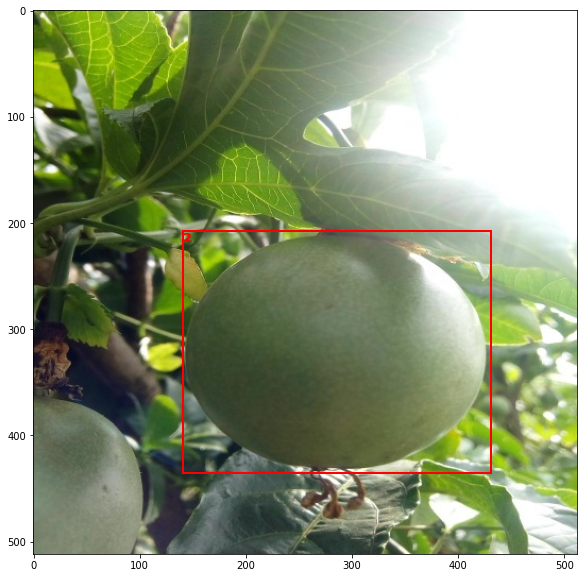

In [48]:
bbox = target['boxes'].numpy()
fig,ax = plt.subplots(1,figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in target["labels"]:
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l.tolist(), verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

## Predicted box for the sample Image

In [49]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = img.permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    for l in target["labels"]:
        for i in range(len(bbox)):
            if val_scores[i]>=detect_thresh:
                box = bbox[i]
                x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
                rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
                ax.text(*box[:2], "class " + str(l.tolist()) + " score {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
                ax.add_patch(rect)
        plt.show()

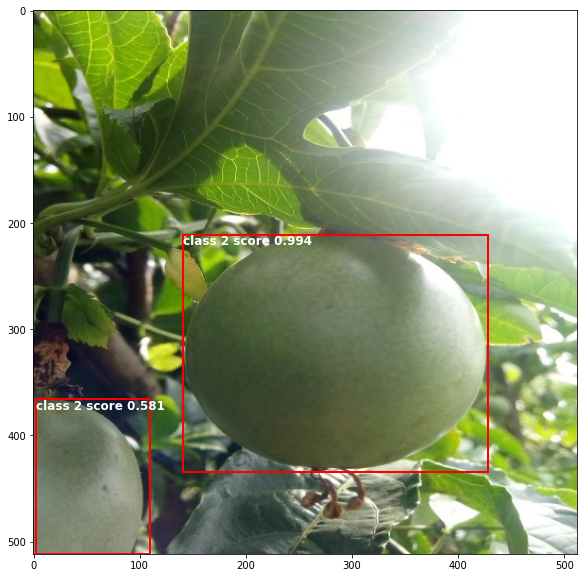

In [50]:
plot_valid(img,prediction)

## Load the Submission Files

In [51]:
submission = pd.read_csv('../input/makerere-fruit-passion/New Makerere/New Makerere/Test.csv')

In [52]:
class TestDataset(object):
    def __init__(self, df, IMG_DIR, transforms):        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['Image_ID'].tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):        
        image_id = self.image_ids[idx]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

In [53]:
class One_Image(object):
    def __init__(self,IMG_PATH, transforms):        
        
        self.img_path = IMG_PATH
        self.transforms = transforms

    
    def __getitem__(self, idx=0):        
        image = cv2.imread(self.img_path,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
        return image

In [54]:
def get_test_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE),
        ToTensorV2(p=1.0)
    ])

In [55]:
test_img_dir = '../input/makerere-fruit-passion/New Makerere/New Makerere/Test_Images(1)/Test_Images/'
test_img_path = '../input/makerere-fruit-passion/New Makerere/New Makerere/Test_Images(1)/Test_Images/ID_14EC1H1R.jpg'

In [56]:
IMG_SIZE = (512,512)

In [57]:
test_dataset = TestDataset(submission, test_img_dir ,get_test_transform())


In [58]:
one_dataset = One_Image('../input/makerere-fruit-passion/New Makerere/New Makerere/Test_Images(1)/Test_Images/ID_14EC1H1R.jpg', get_test_transform())
one_dataset

In [59]:
img = one_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))

predicted #boxes:  10


In [60]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = one_dataset[0].permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    
    for i in range(len(bbox)):
        if val_scores[i]>=detect_thresh:
            box = bbox[i]
            x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
            ax.text(*box[:2], "class " + str(l.tolist()) + " score {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
            ax.add_patch(rect)
    plt.show()

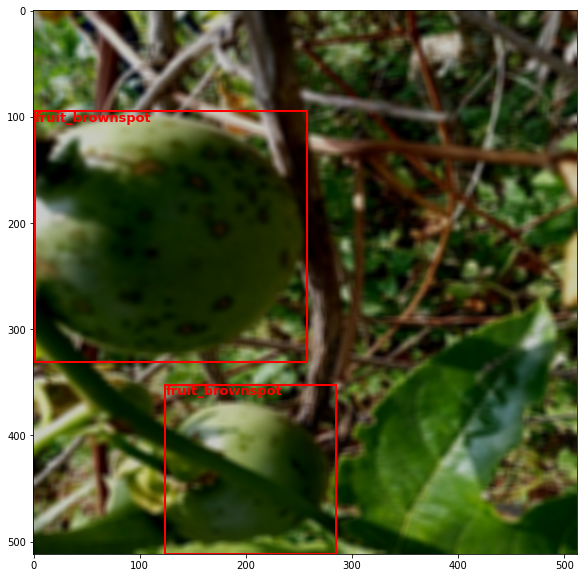

In [61]:
img, tar, _ = passion_dataset[random.randint(0,1000)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"fruit_brownspot",  2:"fruit_healthy", 3:"fruit_woodiness"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


In [70]:
# plot_valid(img,prediction)

In [63]:
results = []


img = one_dataset[0]
img = img.unsqueeze_(0)
# put the model in evaluation mode
model.eval()

with torch.no_grad():
    prediction = model([img.to(device)][0])
    aa = zip(prediction[0]["boxes"].tolist(), prediction[0]["labels"].tolist(), prediction[0]["scores"].tolist())

    for item in list(aa):
        row_dict = {}
        row_dict["Image_ID"] = _
        row_dict["boxes"] = item[0]
        row_dict["labels"] = item[1]
        row_dict["confidence"] = item[2]
        results.append(row_dict)
sub_df = pd.DataFrame(results)
print(prediction)

[{'boxes': tensor([[183.5684,   0.0000, 389.1725, 231.0722],
        [511.9568, 346.8146, 512.0000, 353.8650],
        [511.9890, 113.8250, 512.0000, 120.9464],
        [511.9538, 116.4000, 512.0000, 123.5239],
        [511.9890, 113.7943, 512.0000, 120.9479],
        [511.9539, 116.3694, 512.0000, 123.5254],
        [511.9569, 346.7843, 512.0000, 353.8664],
        [511.9891, 113.8076, 512.0000, 120.9383],
        [511.9543, 116.3826, 512.0000, 123.5158],
        [511.9573, 346.7973, 512.0000, 353.8569]], device='cuda:0'), 'labels': tensor([1, 3, 3, 3, 2, 2, 2, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9855, 0.1641, 0.1641, 0.1641, 0.1628, 0.1628, 0.1628, 0.1535, 0.1535,
        0.1535], device='cuda:0')}]


In [64]:
results = []
for j in range(submission.shape[0]):
    
    img,_ = test_dataset[j]
    img = img.unsqueeze_(0)
    # put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        prediction = model([img.to(device)][0])
        aa = zip(prediction[0]["boxes"].tolist(), prediction[0]["labels"].tolist(), prediction[0]["scores"].tolist())
       
        for item in list(aa):
            row_dict = {}
            row_dict["Image_ID"] = _
            row_dict["boxes"] = item[0]
            row_dict["labels"] = item[1]
            row_dict["confidence"] = item[2]
            results.append(row_dict)
sub_df = pd.DataFrame(results)

In [65]:
sub_df["ymin"] = sub_df["boxes"].apply(lambda x: x[1])
sub_df["xmin"] = sub_df["boxes"].apply(lambda x: x[0])
sub_df["ymax"] = sub_df["boxes"].apply(lambda x: x[3])
sub_df["xmax"]=  sub_df["boxes"].apply(lambda x: x[2])

In [66]:
classes_la = {0:"Background", 1:"fruit_brownspot", 2:"fruit_healthy", 3:"fruit_woodiness"}
sub_df["labels"] = sub_df["labels"].apply(lambda x: classes_la[x])

In [67]:
sub_df.drop(["boxes"], axis=1, inplace=True)
sub_df.rename(columns={"labels":"class"}, inplace=True)
sub_df.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_IUJJG62B,fruit_healthy,0.996786,148.701904,76.159538,397.277954,374.028381
1,ID_IUJJG62B,fruit_healthy,0.950104,311.482269,284.873260,477.032318,480.001251
2,ID_IUJJG62B,fruit_healthy,0.916796,399.674225,441.155701,484.409821,512.000000
3,ID_IUJJG62B,fruit_healthy,0.316804,351.884613,428.225159,481.930695,505.964294
4,ID_IUJJG62B,fruit_woodiness,0.160526,313.746826,282.908417,479.119781,478.477173


In [68]:
sub_df.shape

(3391, 7)

In [69]:
sub_df.to_csv("new.csv", index=False)